In [1]:
from train import train_model
from utils import load_config, load_model, inference
from utils import visualize_output, get_keypoints_from_heatmaps
import cv2
import numpy as np
from dataset import PoseDataset
import torch
import matplotlib.pyplot as plt

In [2]:
config = './configs/config_w48_384x288.yaml'
run = '20240930_114636'
epoch = 3

config1 = load_config(config)
config2 = load_config(config)
config2['model']['weights'] = f'runs/{run}/checkpoint_epoch_{epoch}/weights_epoch_{epoch}.pth'

In [3]:
img_size = config1['dataset']['preprocess']['input_size']
img_size = (img_size[1], img_size[0])

n = 5
dataset = PoseDataset(config1["dataset"], config1["dataset"]['val'])

# get n random images
samples = []
images = []
for i in range(n):
    idx = np.random.randint(0, len(dataset))
    image,target,keypoints_gt,keypoint_visibility = dataset[idx]
    samples.append((image,target,keypoints_gt,keypoint_visibility))
    images.append(image)

images = torch.stack(images)

In [4]:
result1 = inference(config1, images)
keypoints1 = get_keypoints_from_heatmaps(result1, img_size)
result2 = inference(config2, images)
keypoints2 = get_keypoints_from_heatmaps(result2, img_size)

Skipping final_layer.weight due to shape mismatch: Error(s) in loading state_dict for PoseHighResolutionNet:
	size mismatch for final_layer.weight: copying a param with shape torch.Size([17, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 48, 1, 1]).
Skipping final_layer.bias due to shape mismatch: Error(s) in loading state_dict for PoseHighResolutionNet:
	size mismatch for final_layer.bias: copying a param with shape torch.Size([17]) from checkpoint, the shape in current model is torch.Size([34]).


In [5]:
def show_result(image, keypoints1, keypoints2, keypoints_gt):
    image_show = image.permute(1,2,0).numpy().copy()

    keypoints1 = keypoints1.numpy()
    keypoints2 = keypoints2.numpy()


    # for i in range(keypoints1.shape[0]):
    #     cv2.circle(image_show, (int(keypoints1[i][0]), int(keypoints1[i][1])), 2, (0,0,255), -1)

    # for i in range(len(keypoints_gt)):
    #     cv2.circle(image_show, (int(keypoints_gt[i][0]), int(keypoints_gt[i][1])), 3, (0,255,0), -1)

    # for i in range(keypoints2.shape[0]):
    #     cv2.circle(image_show, (int(keypoints2[i][0]), int(keypoints2[i][1])), 2, (255,0,0), -1)

    # # add labels
    # cv2.putText(image_show, 'Ground Truth', (5, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 255, 0), 1)
    # cv2.putText(image_show, 'Predicted 1', (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1)
    # cv2.putText(image_show, 'Predicted 2', (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (255, 0, 0), 1)

    # show image in notebook cell with matplotlib
    plt.axis('off')
    plt.imshow(image_show)
    plt.plot(keypoints1[:,0], keypoints1[:,1], 'bo', markersize=3)
    plt.plot(keypoints_gt[:,0], keypoints_gt[:,1], 'go', markersize=3)
    plt.plot(keypoints2[:,0], keypoints2[:,1], 'ro', markersize=3)
    plt.legend(['Base', 'Ground Truth', 'Model'])

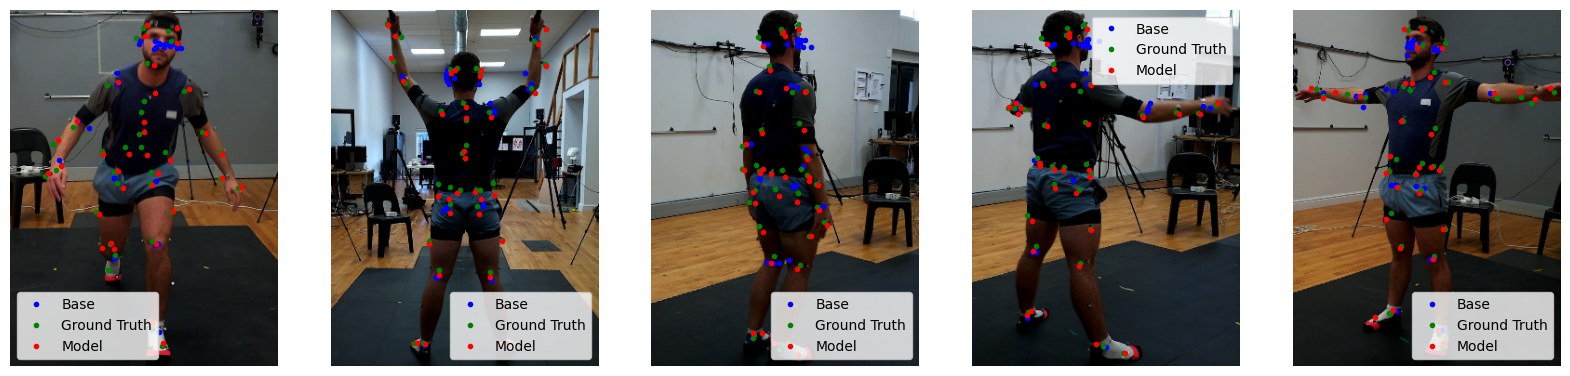

In [6]:
# show samples in grid
plt.figure(figsize=(20, 10))
for i, (image, target, keypoints_gt, keypoint_visibility) in enumerate(samples):
    plt.subplot(1, n, i+1)
    show_result(image, keypoints1[i], keypoints2[i], keypoints_gt)
# add legend
plt.show()

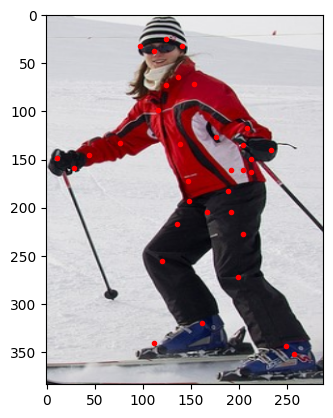

In [7]:
image = cv2.imread('./example_images/demo_cropped.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, img_size[::-1])
image = torch.tensor(image).permute(2,0,1).unsqueeze(0).float()
image = image / 255.0

result1 = inference(config2, image)

keypoints1 = get_keypoints_from_heatmaps(result1, img_size)

plt.imshow(image[0].permute(1,2,0))
plt.plot(keypoints1[0,:,0], keypoints1[0,:,1], 'ro', markersize=3)

plt.show()